## ADS Final Project
### Disaggregating the energy usage of residential buildings
#### team members :  Haopeng Huang, Songjian Li, Muci Yu


The data is from the REDD data set
This is the home page for the REDD data set. Below you can download an initial version of the data set, containing several weeks of power data for 6 different homes, and high-frequency current/voltage data for the main power supply of two of these homes. The data itself and the hardware used to collect it are described more thoroughly in the Readme below and in the paper:

J. Zico Kolter and Matthew J. Johnson. REDD: A public data set for energy disaggregation research. In proceedings of the SustKDD workshop on Data Mining Applications in Sustainability, 2011.

REDD: supervised learning on the energy disaggregation problem

##### Here we test some machine learning algorithm on extracting the refrigerator energy from mains consumptions. REDD contains data of 6 houses. We first train, test the model only on data from house 1 and check how well the model performs on the unseen-pattern data of house 2.  

#### Import packages, read house 1 and house 2 data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

In [3]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = 'Data/low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,3):
    print('House {}: '.format(i), labels[i], '\n')

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 



In [4]:
def read_merge_data(house):
    path = 'Data/low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df
df = {}
for i in range(1,3):
    df[i] = read_merge_data(i)

In [5]:
'''for i in range(1,3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))'''
    

"for i in range(1,3):\n    print('House {} data has shape: '.format(i), df[i].shape)\n    display(df[i].tail(3))"

In [6]:
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 



### Train and test on house 1 - Decision tree regression

In [7]:
# Separate house 1 data into train, validation and test data
df1_train = df[1].ix[:dates[1][10]]
df1_val = df[1].ix[dates[1][11]:dates[1][16]]
df1_test = df[1].ix[dates[1][17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (214816, 20)
df_val.shape:  (104875, 20)
df_test.shape:  (87057, 20)


In [8]:
df1_train.head()

mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-04-18 13:22:13   222.20   118.83     0.0     0.0             6.0   
2011-04-18 13:22:16   223.17   119.19     0.0     0.0             6.0   
2011-04-18 13:22:20   223.60   118.92     0.0     0.0             6.0   
2011-04-18 13:22:23   222.91   119.16     0.0     0.0             6.0   
2011-04-18 13:22:26   222.94   118.83     0.0     0.0             6.0   

                     dishwaser_6  kitchen_outlets_7  kitchen_outlets_8  \
2011-04-18 13:22:13          0.0               34.0               21.0   
2011-04-18 13:22:16          0.0               34.0               21.0   
2011-04-18 13:22:20          0.0               34.0               22.0   
2011-04-18 13:22:23          1.0               35.0               21.0   
2011-04-18 13:22:26          0.0               34.0               21.0   

                     lighting_9  washer_dryer_10  microwave_11  \
2011-04-18 13:22:13        81.0              0.0           5.0   
2011-04-18 13:22:16        81.0              0.0           5.0   
2011-04-18 13:22:20        81.0              0.0           5.0   
2011-04-18 13:22:23        81.0              0.0           5.0   
2011-04-18 13:22:26        81.0              0.0           5.0   

                     bathroom_gfi_12  electric_heat_13  stove_14  \
2011-04-18 13:22:13              1.0               0.0       0.0   
2011-04-18 13:22:16              1.0               0.0       0.0   
2011-04-18 13:22:20              1.0               0.0       0.0   
2011-04-18 13:22:23              1.0               0.0       0.0   
2011-04-18 13:22:26              1.0               0.0       0.0   

                     kitchen_outlets_15  kitchen_outlets_16  lighting_17  \
2011-04-18 13:22:13                 2.0                 0.0         65.0   
2011-04-18 13:22:16                 2.0                 0.0         65.0   
2011-04-18 13:22:20                 2.0                 0.0         65.0   
2011-04-18 13:22:23                 1.0                 0.0         65.0   
2011-04-18 13:22:26                 2.0                 0.0         65.0   

                     lighting_18  washer_dryer_19  washer_dryer_20  
2011-04-18 13:22:13         46.0              0.0              0.0  
2011-04-18 13:22:16         46.0              0.0              0.0  
2011-04-18 13:22:20         46.0              0.0              0.0  
2011-04-18 13:22:23         46.0              0.0              0.0  
2011-04-18 13:22:26         46.0              0.0              0.0

In [7]:
# Using mains_1, mains_2 to predict refrigerator
X_train1 = df1_train[['mains_1','mains_2']].values
y_train1 = df1_train['refrigerator_5'].values
X_val1 = df1_val[['mains_1','mains_2']].values
y_val1 = df1_val['refrigerator_5'].values
X_test1 = df1_test[['mains_1','mains_2']].values
y_test1 = df1_test['refrigerator_5'].values
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

(214816, 2) (214816,) (104875, 2) (104875,) (87057, 2) (87057,)


In [8]:
# Using decision tree regression, here we use validation data to turn the min_samples_split parameter
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

min_samples_split=np.arange(2, 400, 10)
from sklearn.tree import DecisionTreeRegressor
def tree_reg(X_train, y_train, X_val, y_val, min_samples_split):
    clfs = []
    losses = []
    start = time.time()
    for split in min_samples_split:
        clf = DecisionTreeRegressor(min_samples_split = split)
        clf.fit(X_train, y_train)
        y_predict_val = clf.predict(X_val)
        clfs.append(clf)
        losses.append( mse_loss(y_predict_val, y_val) )
    print('Trainning time: ', time.time() - start)
    return clfs, losses
# tree_clfs_1, tree_losses_1 = tree_reg(X_train1, y_train1, X_val1, y_val1, min_samples_split)

In [9]:
# Plot real and predict refrigerator consumption on six days of test data
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.ix[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)


# plot_each_app(df1_test, dates[1][17:], y_test_predict_1, y_test1, 'Real and predict Refrigerator on 6 test day of house 1')

In [ ]:
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.ix[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)

### Now, let's try fully connected neural network
#### For faster implementation, we use keras API with TensorFlow backend 

In [10]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [11]:
def build_fc_model(layers):
    fc_model = Sequential()
    for i in range(len(layers)-1):
        fc_model.add( Dense(input_dim=layers[i], output_dim= layers[i+1]) )#, W_regularizer=l2(0.1)) )
        fc_model.add( Dropout(0.5) )
        if i < (len(layers) - 2):
            fc_model.add( Activation('relu') )
    fc_model.summary()
    return fc_model
fc_model_1 = build_fc_model([2, 256, 512, 1024, 1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
__________

In [ ]:
adam = Adam(lr = 0.001)
fc_model_1.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1_2_new.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( X_train1, y_train1,
                    batch_size=256, verbose=1, nb_epoch=100,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Train on 143926 samples, validate on 70890 samples
Epoch 1/100


In [ ]:
fc_model_1 = load_model('fc_refrig_h1_2.hdf5')
pred_fc_1 = fc_model_1.predict(X_test1).reshape(-1)
mse_loss_fc_1 = mse_loss(pred_fc_1, y_test1)
mae_loss_fc_1 = mae_loss(pred_fc_1, y_test1)
print('Mean square error on test set: ', mse_loss_fc_1)
print('Mean absolute error on the test set: ', mae_loss_fc_1)


In [ ]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

In [ ]:
plot_each_app(df1_test, dates[1][17:], pred_fc_1, y_test1, 
              'FC model: real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Use this model on house 2

In [44]:
y_pred_fc_2 = fc_model_1.predict(X_2).reshape(-1)
mse_fc_2 = mse_loss(y_pred_fc_2, y_2)
mae_fc_2 = mae_loss(y_pred_fc_2, y_2)
print('Mean square error on test set: ', mse_fc_2)
print('Mean absolute error on the test set: ', mae_fc_2)

Mean square error on test set:  4081.55138568
Mean absolute error on the test set:  37.7227043683


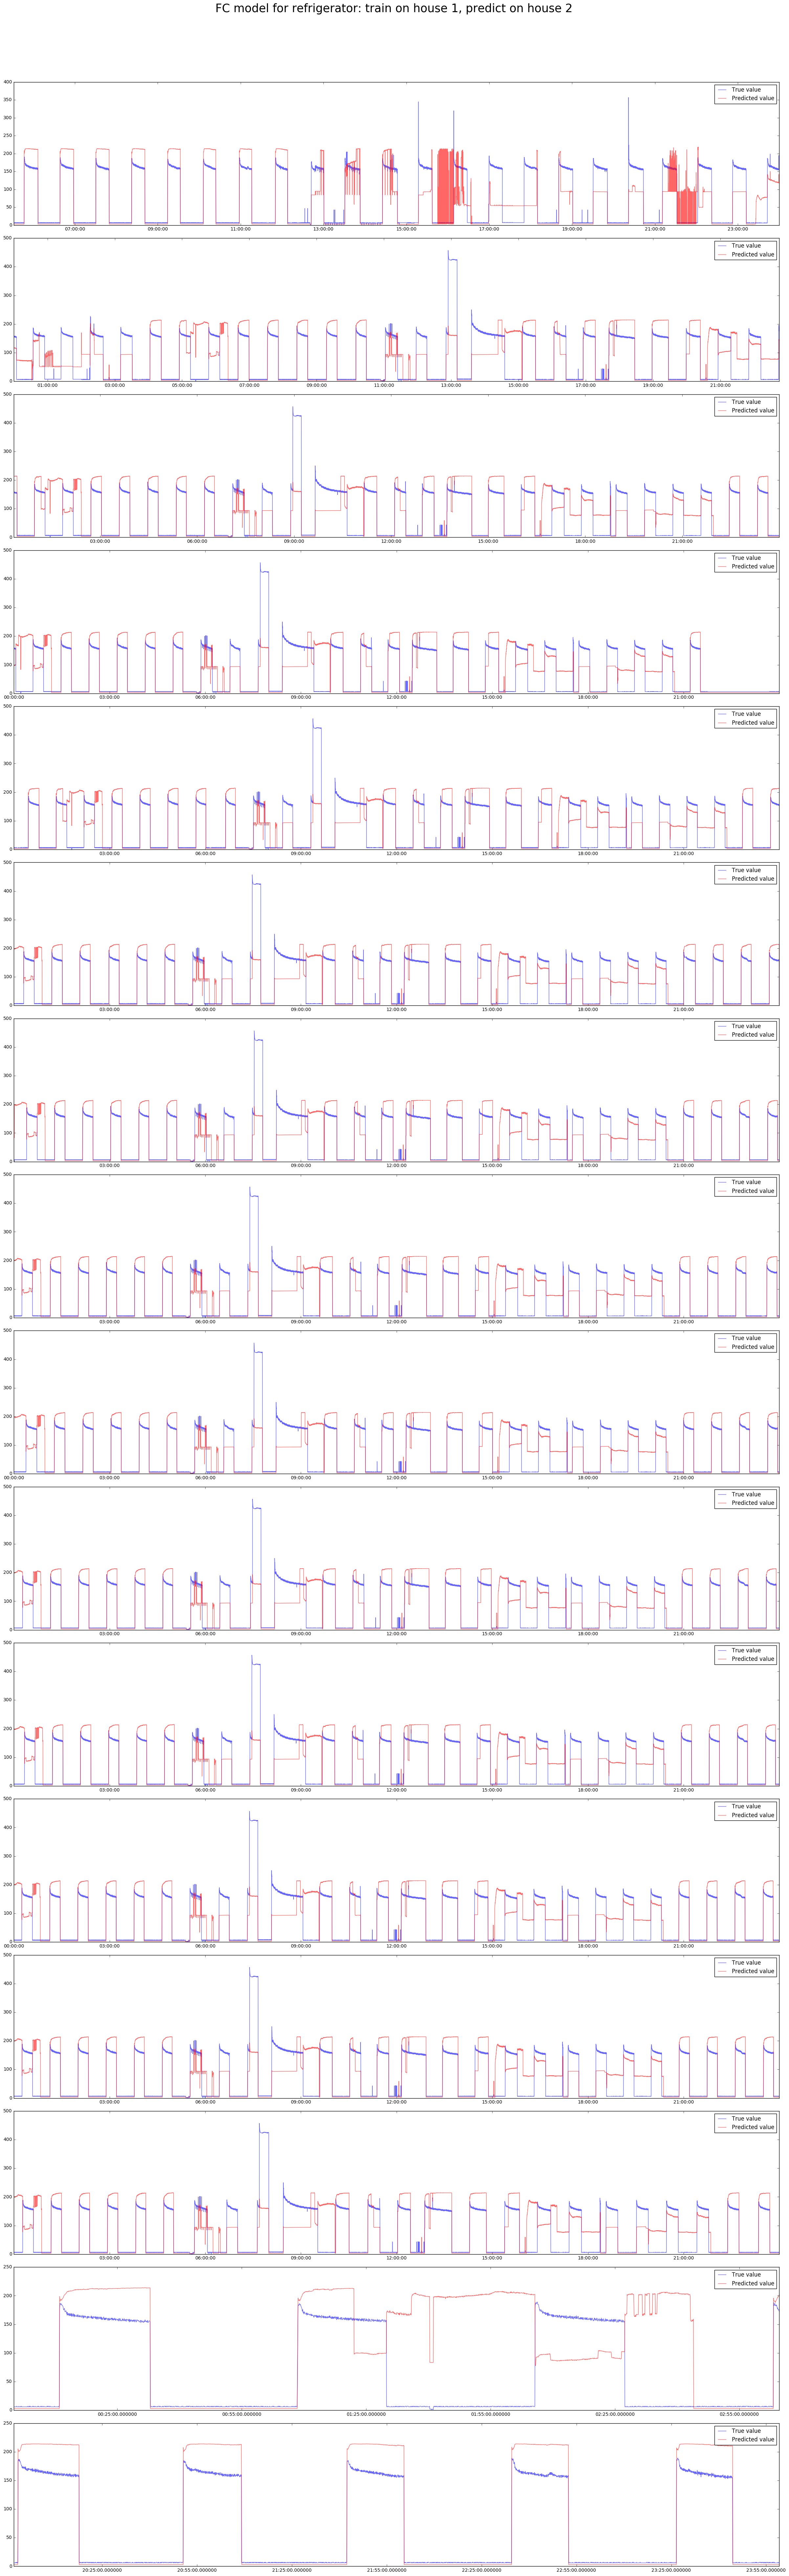

In [45]:
plot_each_app(df[2], dates[2], y_pred_fc_2, y_2, 'FC model for refrigerator: train on house 1, predict on house 2')

### Let's use 50 consecutive total consumtions to predict energy consumption of each appliance

In [46]:
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        data = df.ix[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back] 
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 2)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X,Y

In [47]:
start = time.time()
X_train, y_train = process_data(df[1], dates[1][:17], ['mains_1','mains_2'], df[1].columns.values[2:])
X_test, y_test = process_data(df[1], dates[1][17:], ['mains_1','mains_2'], df[1].columns.values[2:])
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  131.1120023727417
(318841, 50, 2) (318841, 18) (86757, 50, 2) (86757, 18)


#### Let's use fully connected neural network again, but this time we use the past 50 consecutive main values to predict the present value of refrigerator


In [48]:
fc_model = build_fc_model([100, 256, 512, 1024, 1])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 256)           25856       dense_input_6[0][0]              
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 256)           0           dense_5[0][0]                    
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 256)           0           dropout_5[0][0]                  
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 512)           131584      activation_4[0][0]               
___________________________________________________________________________________________

In [49]:
# Let's flatten data to feed into fc model
X_train_fc = X_train.reshape(-1, 100)
y_train_fc = y_train[:,2]
print(X_train_fc.shape, y_train_fc.shape)

(318841, 100) (318841,)


In [52]:
adam = Adam(lr = 1e-5)
fc_model.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1.hdf5", verbose=0, save_best_only=True)
hist_fc2 = fc_model.fit( X_train_fc, y_train_fc,
                    batch_size=512, verbose=1, nb_epoch= 200,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Train on 213623 samples, validate on 105218 samples
Epoch 1/200
213623/213623 [==============================] - 2s - loss: 6505.4981 - val_loss: 5682.7645
Epoch 2/200
213623/213623 [==============================] - 1s - loss: 6524.7784 - val_loss: 5680.6661
Epoch 3/200
213623/213623 [==============================] - 1s - loss: 6522.5690 - val_loss: 5571.7637
Epoch 4/200
213623/213623 [==============================] - 1s - loss: 6460.9373 - val_loss: 5674.6952
Epoch 5/200
213623/213623 [==============================] - 1s - loss: 6515.9020 - val_loss: 5748.6559
Epoch 6/200
213623/213623 [==============================] - 1s - loss: 6529.6990 - val_loss: 5641.3719
Epoch 7/200
213623/213623 [==============================] - 1s - loss: 6454.8584 - val_loss: 5573.4369
Epoch 8/200
213623/213623 [==============================] - 1s - loss: 6491.9831 - val_loss: 5673.0675
Epoch 9/200
213623/213623 [==============================] - 1s - loss: 6510.2547 - val_loss: 5496.7455
Epoch 10/200

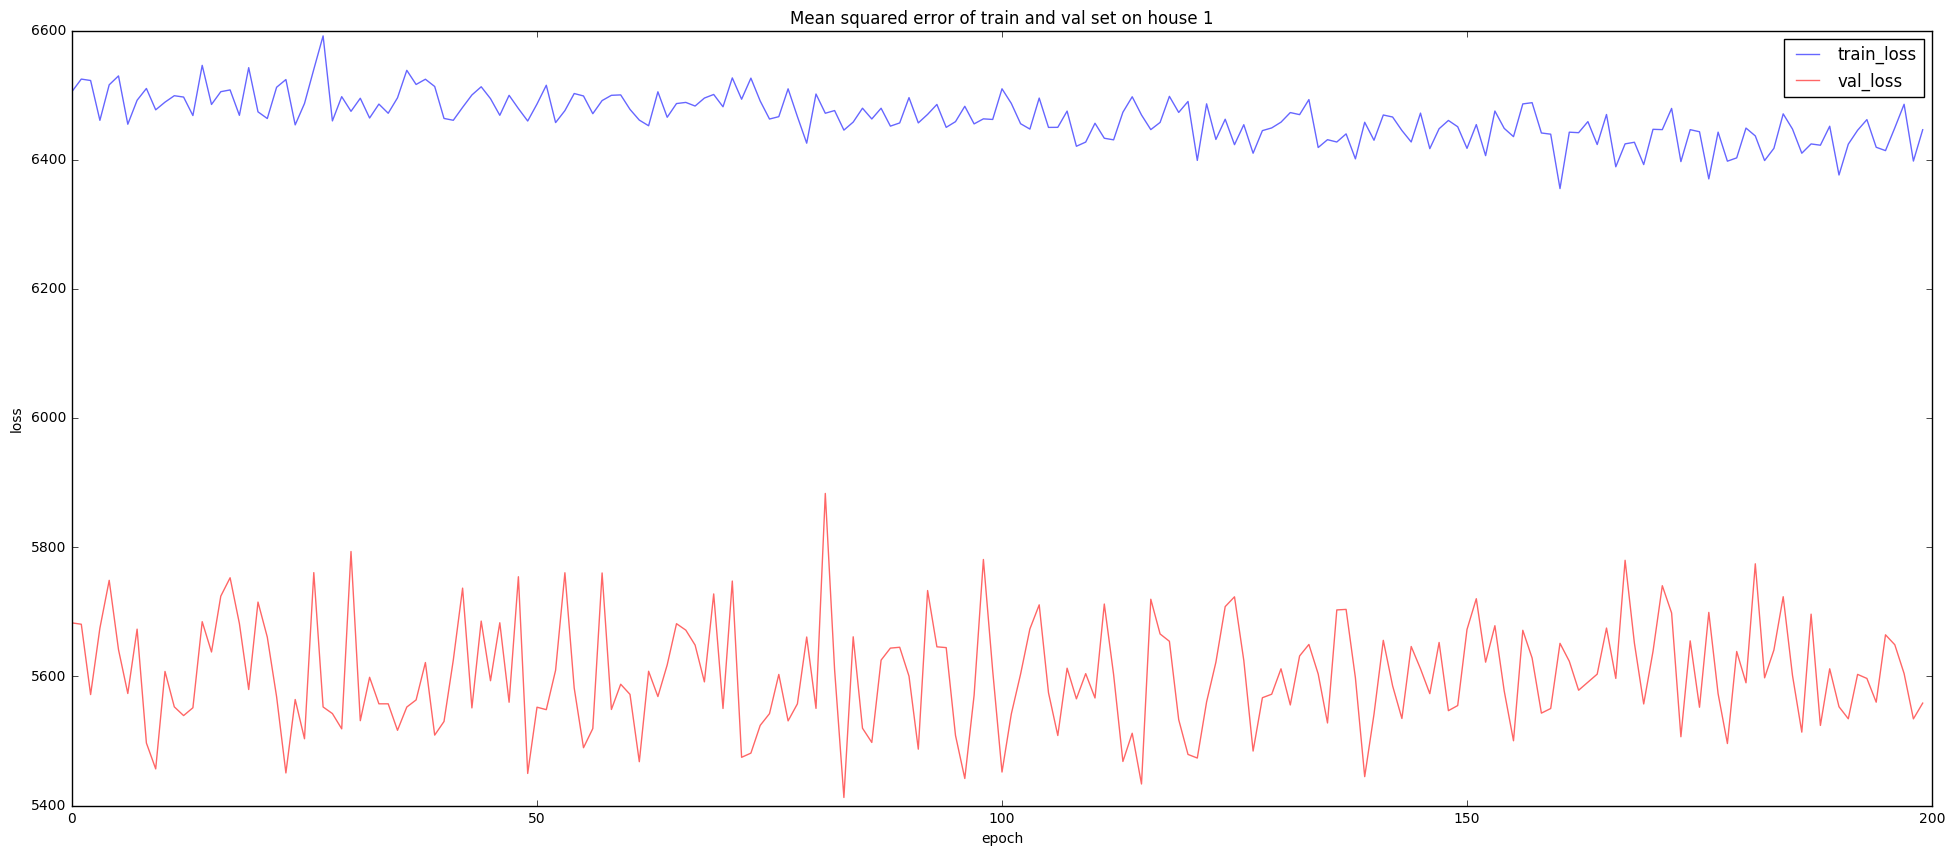

In [53]:
train_loss = hist_fc2.history['loss']
val_loss = hist_fc2.history['val_loss']

plot_losses(train_loss, val_loss)

In [54]:
fc_model = load_model('fc_refrig_h1.hdf5')
pred_fc = fc_model.predict(X_test.reshape(-1, 100)).reshape(-1)
print(pred_fc.shape)

(86757,)


In [55]:
mse_loss_fc = mse_loss(pred_fc, y_test[:,2])
mae_loss_fc = mae_loss(pred_fc, y_test[:,2])
print('Mean square error on test set: ', mse_loss_fc)
print('Mean absolute error on the test set: ', mae_loss_fc)

Mean square error on test set:  6431.12474741
Mean absolute error on the test set:  41.2176835876


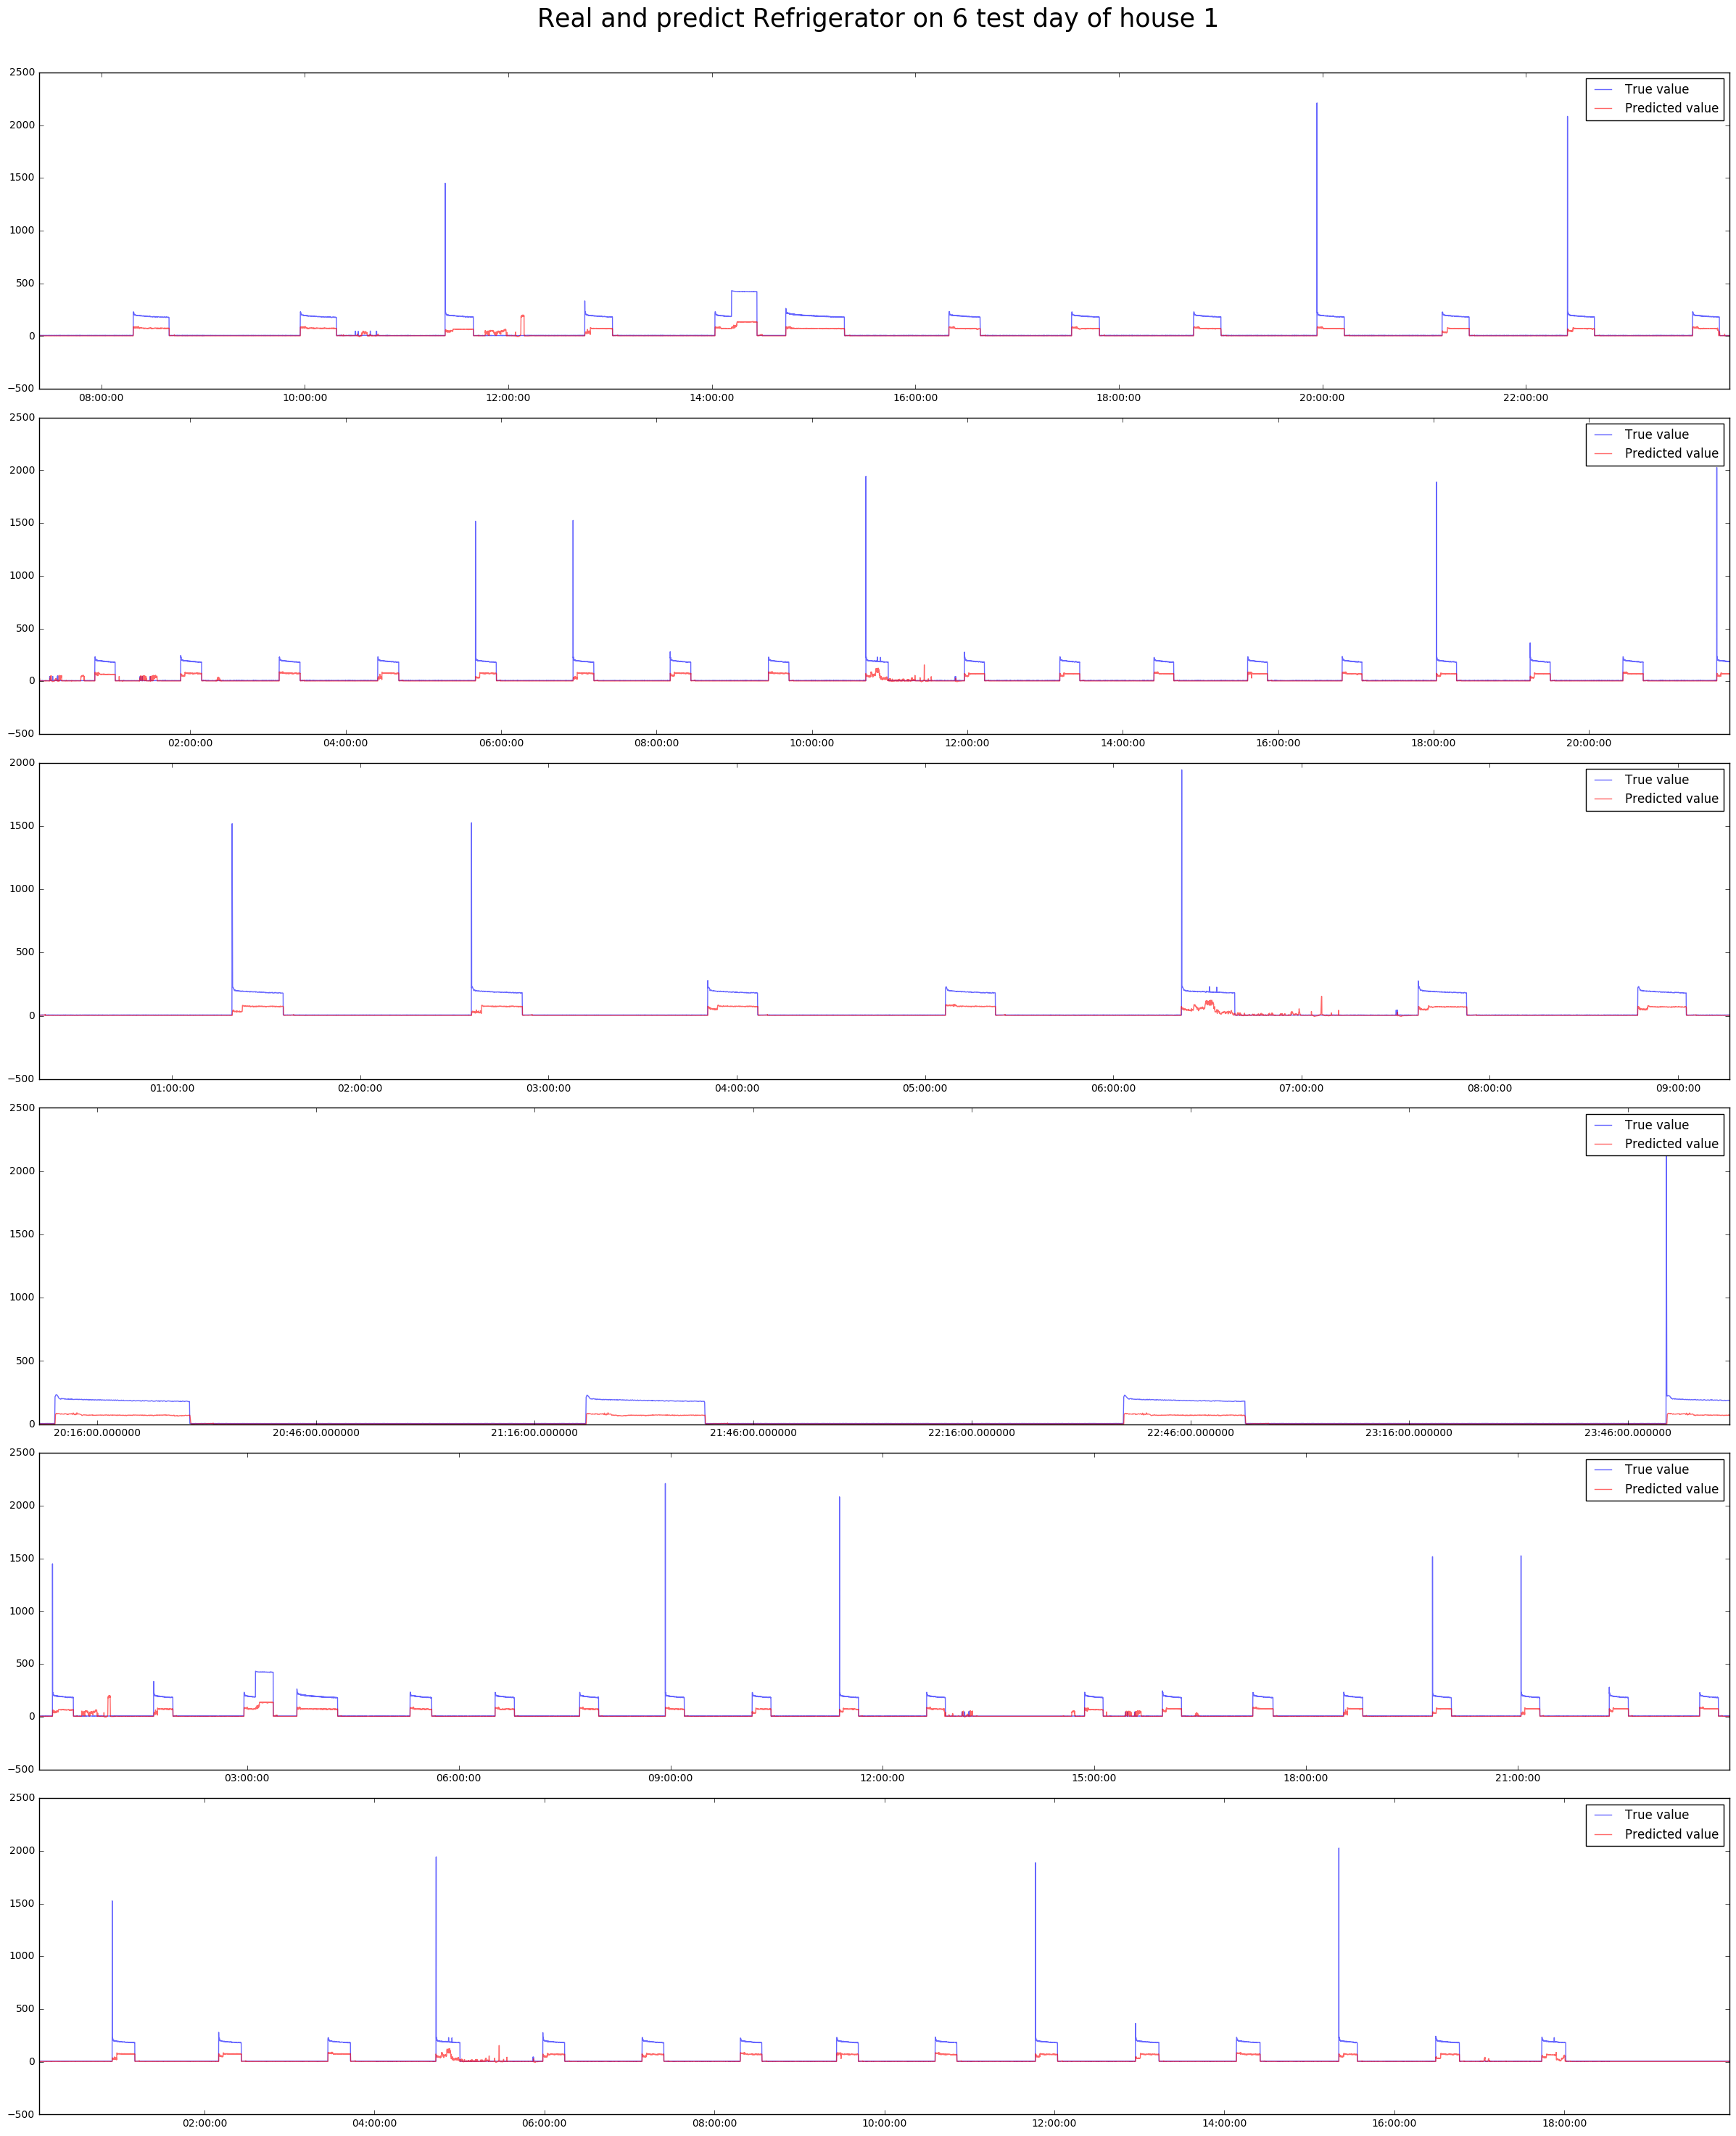

In [56]:
plot_each_app(df1_test, dates[1][17:], pred_fc, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Test on house 2

In [57]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['mains_2','mains_1'], ['refrigerator_9'])
X_2_fc = X_2.reshape(-1, 100)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(X_2_fc.shape, y_2.shape)

Process data time:  101.4786548614502
(316040, 100) (316040,)


In [60]:
pred_fc_50_h2 = fc_model.predict(X_2_fc).reshape(-1)
mse_loss_fc_50_2 = mse_loss(pred_fc_50_h2, y_2)
mae_loss_fc_50_2 = mae_loss(pred_fc_50_h2, y_2)
print('Mean square error on test set: ', mse_loss_fc_50_2)
print('Mean absolute error on the test set: ', mae_loss_fc_50_2)

Mean square error on test set:  7280.34745165
Mean absolute error on the test set:  51.7709722299


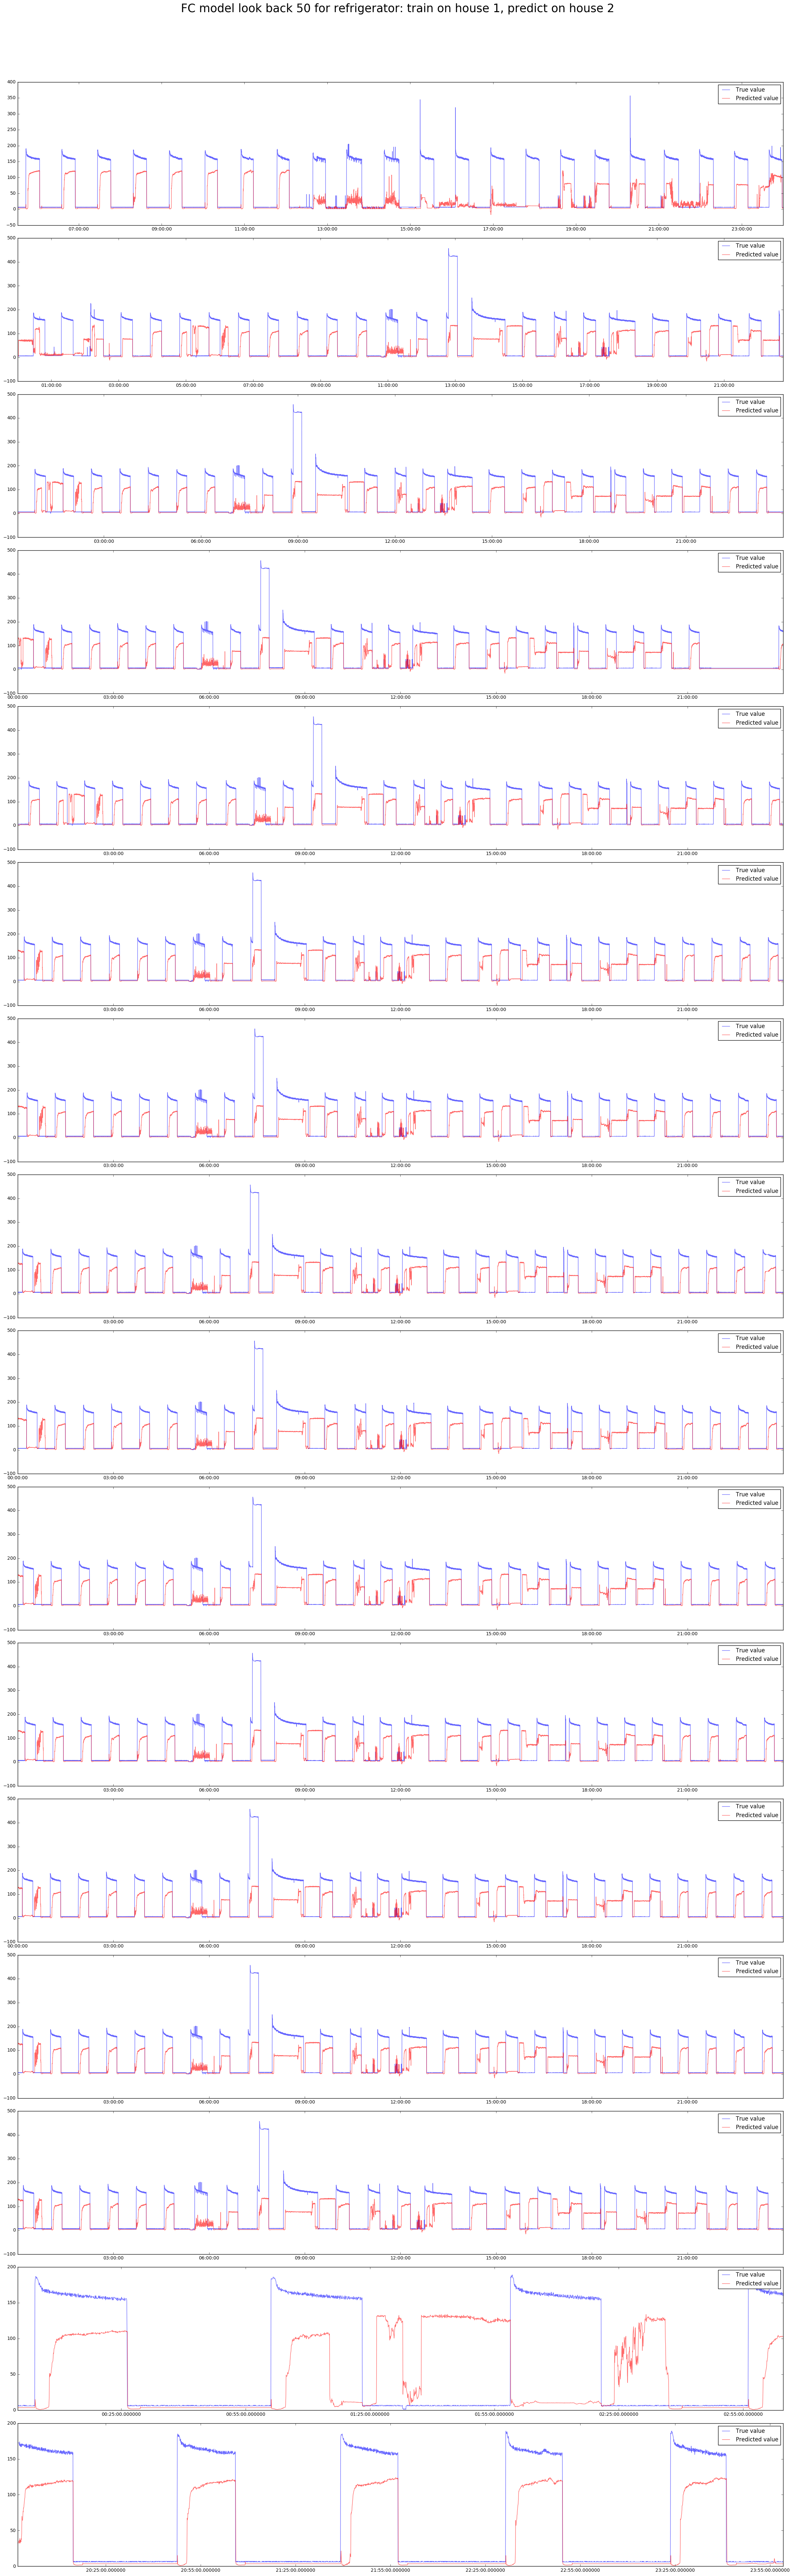

In [61]:
plot_each_app(df[2], dates[2], pred_fc_50_h2, y_2, 'FC model look back 50 for refrigerator: train on house 1, predict on house 2')

### Long term short term memory neural network
#### Now we will try a type of recurrent neural network called long term short term memory model

In [62]:
def build_lstm_model(layers):
    model = Sequential()
    for i in range(len(layers) - 2):
        model.add(LSTM(
            input_dim=layers[i],
            output_dim=layers[i+1], 
            #stateful=True,
            return_sequences= True if i < len(layers) - 3 else False ))
        model.add(Dropout(0.3))
    
    model.add(Dense(layers[-1]))
    model.summary()
    return model

model = build_lstm_model([2,64,128,256, 1])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, None, 64)      17152       lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, None, 64)      0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, None, 128)     98816       dropout_9[0][0]                  
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, None, 128)     0           lstm_2[0][0]                     
___________________________________________________________________________________________

In [ ]:
start = time.time()
adam = Adam(lr = 5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
            X_train,
            y_train[:,2],
            batch_size=512,
            verbose=1,
            nb_epoch=200,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

In [ ]:
train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [63]:
model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
print(pred_lstm.shape)

(86757,)


In [64]:
mse_loss_lstm = mse_loss(pred_lstm, y_test[:,2])
mae_loss_lstm = mae_loss(pred_lstm, y_test[:,2])
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

Mean square error on test set:  2087.58609048
Mean absolute error on the test set:  11.1584995895


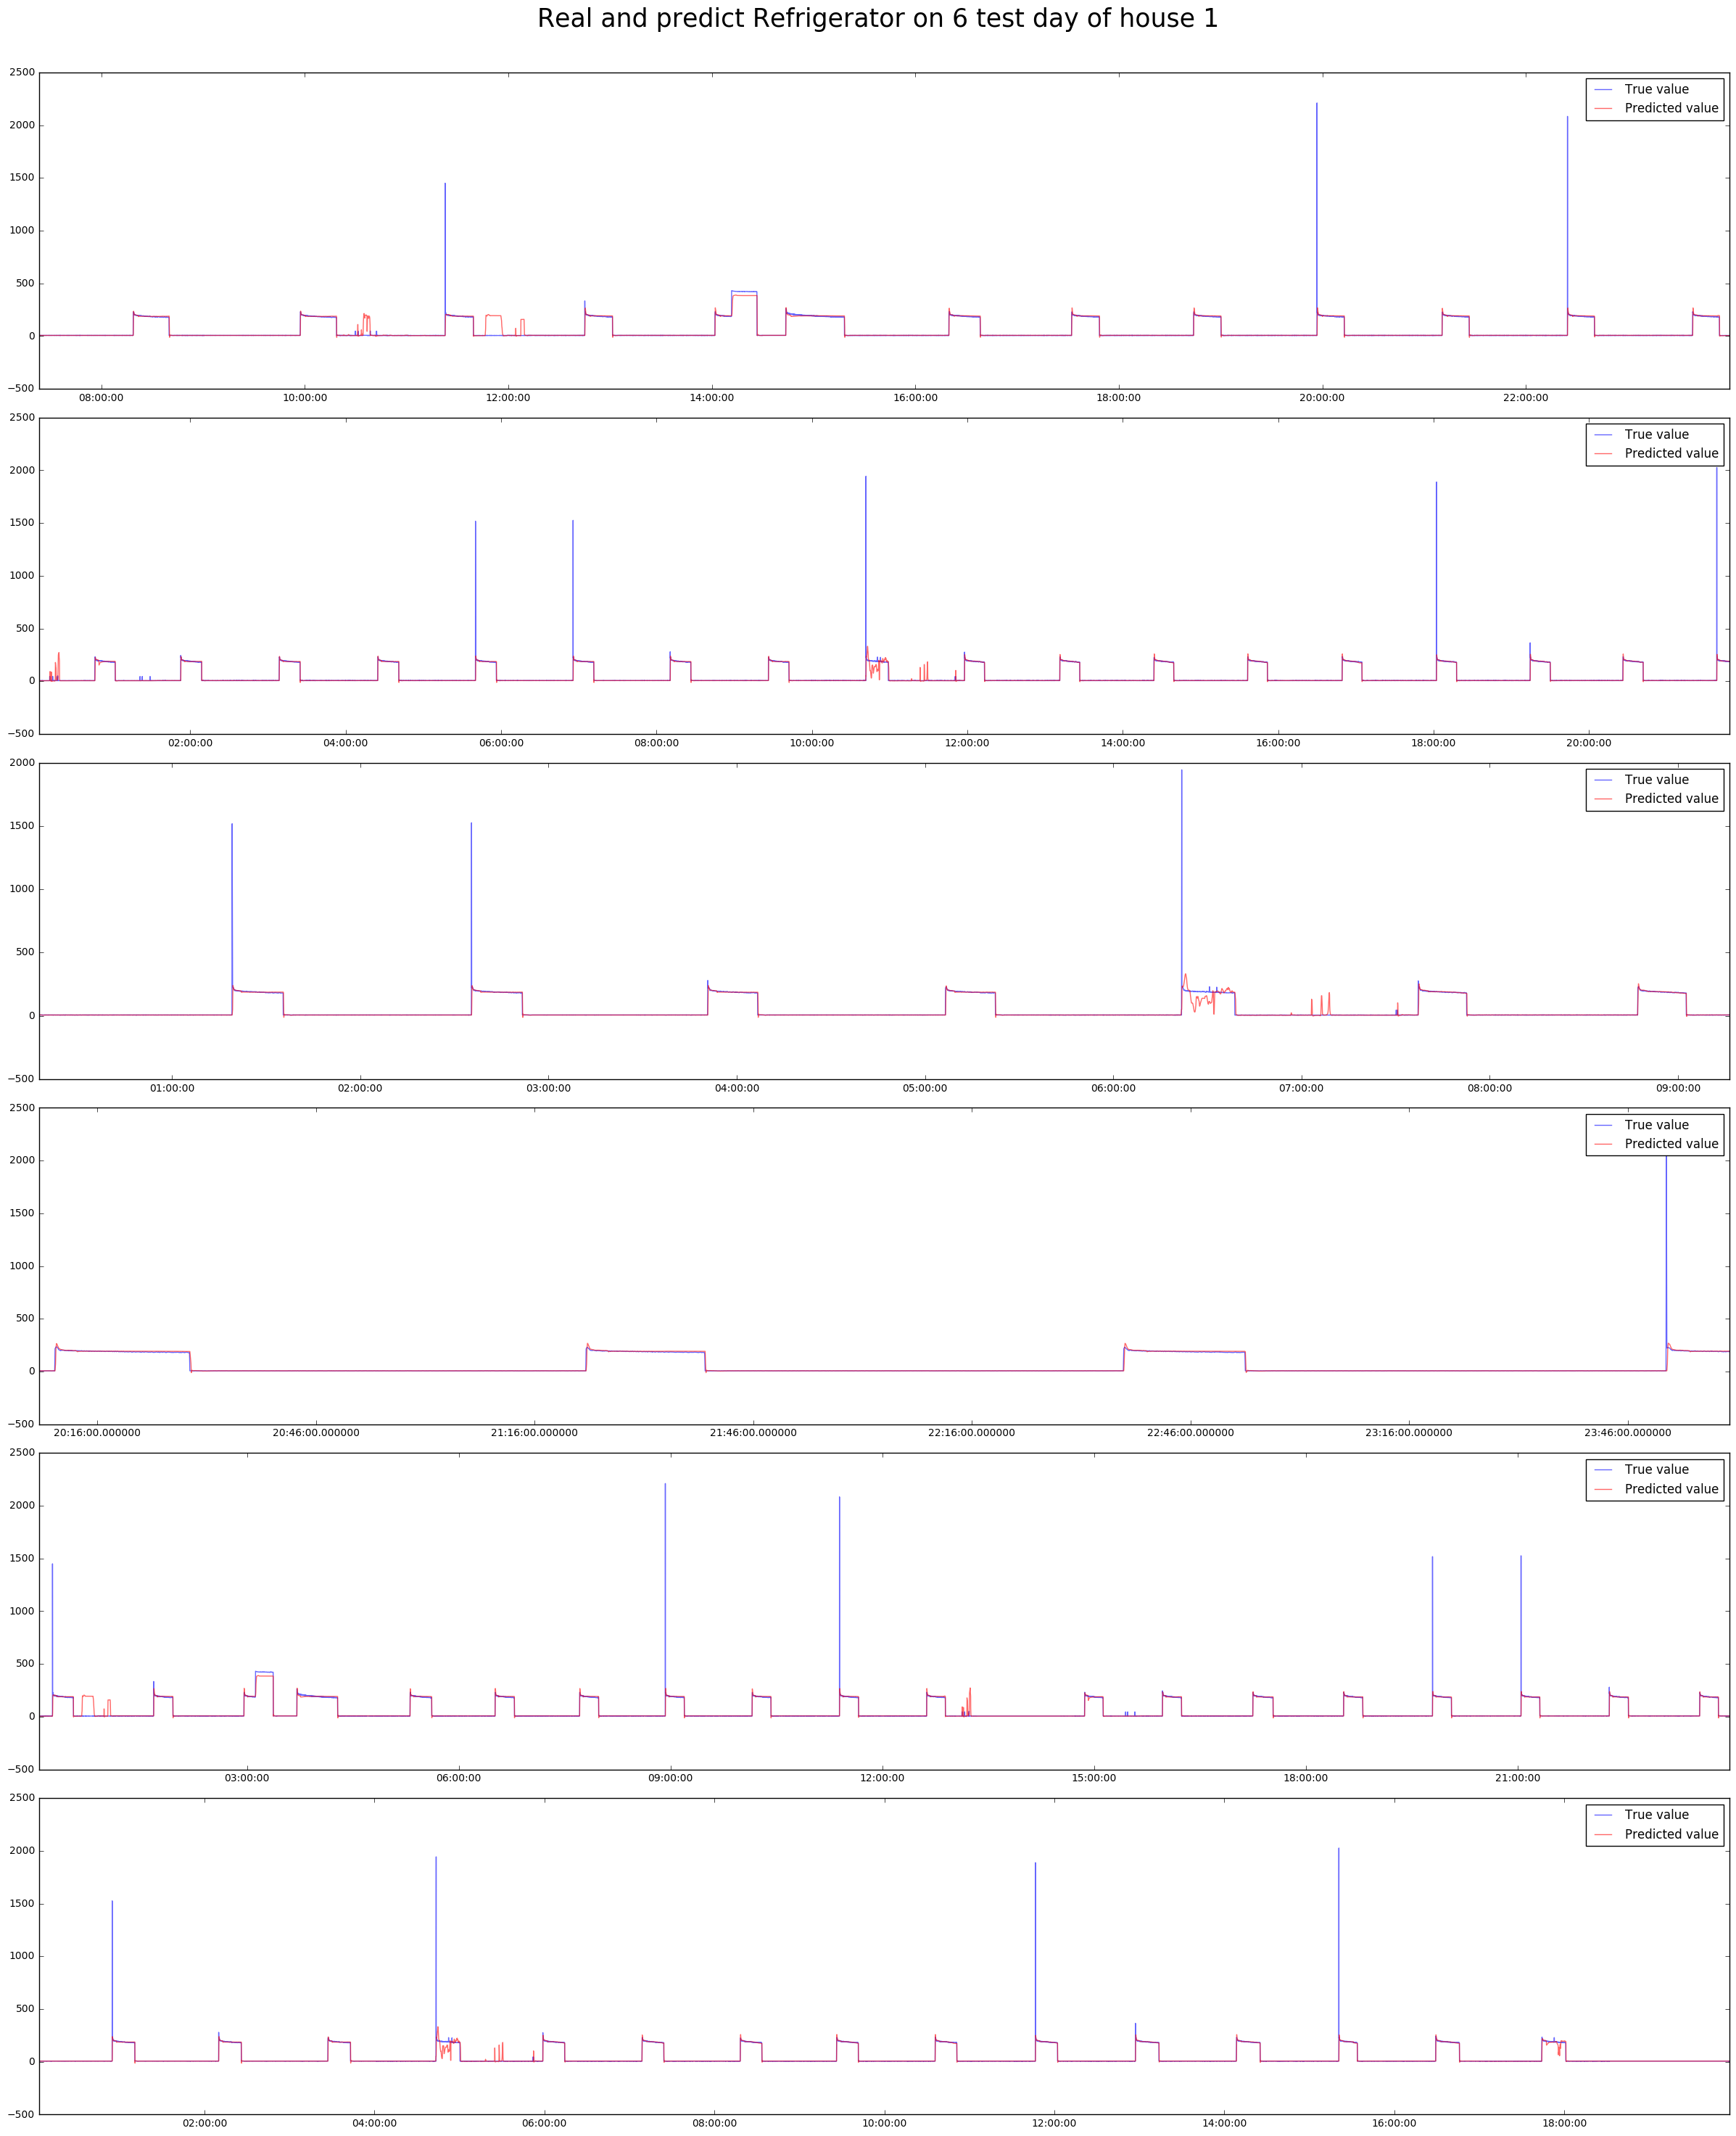

In [65]:
plot_each_app(df1_test, dates[1][17:], pred_lstm, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Test LST model on house 2 

In [66]:
pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)


Mean square error on test set:  21135.549708
Mean absolute error on the test set:  92.0653313527


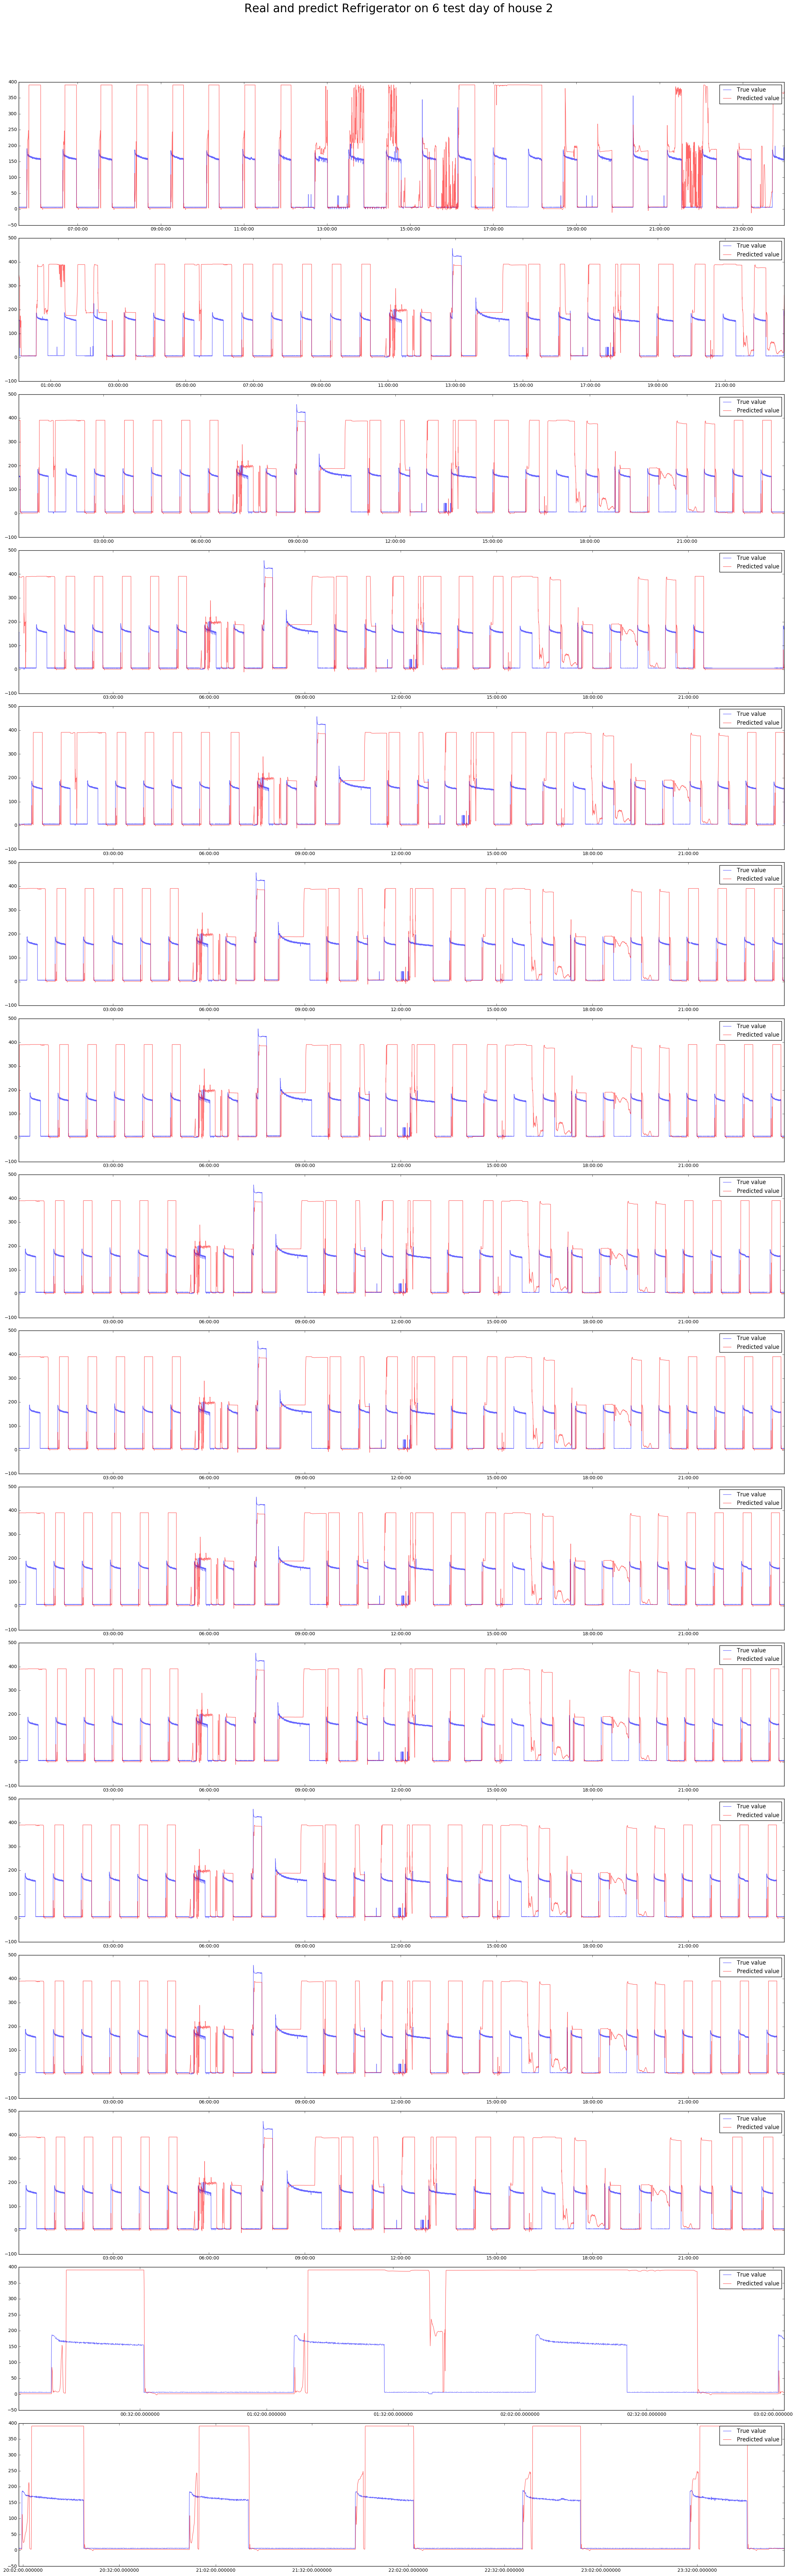

In [67]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2, 
              'Real and predict Refrigerator on 6 test day of house 2', look_back = 50)